In [38]:
from sklearn.model_selection import cross_val_score
from sklearn import neighbors
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import linear_model
import seaborn as sns
import statsmodels.formula.api as smf
from IPython.display import display
import sklearn
from sklearn.preprocessing import normalize
import math
import statsmodels.api as sm
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
os.getcwd()
os.chdir('/Users/kylehoward/desktop/thinkful/thinkful-2/capstone_1') 
os.getcwd()

'/Users/kylehoward/Desktop/Thinkful/Thinkful-2/Capstone_1'

In [39]:
data = ("shot_logs.csv")
df = pd.read_csv(data, usecols=[4,5,6,7,8,9,10,11,12,13,16,17,18,20])
df.describe

<bound method NDFrame.describe of         FINAL_MARGIN  SHOT_NUMBER  PERIOD GAME_CLOCK  SHOT_CLOCK  DRIBBLES  \
0                 24            1       1       1:09        10.8         2   
1                 24            2       1       0:14         3.4         0   
2                 24            3       1       0:00         NaN         3   
3                 24            4       2      11:47        10.3         2   
4                 24            5       2      10:34        10.9         2   
5                 24            6       2       8:15         9.1         2   
6                 24            7       4      10:15        14.5        11   
7                 24            8       4       8:00         3.4         3   
8                 24            9       4       5:14        12.4         0   
9                  1            1       2      11:32        17.4         0   
10                 1            2       2       6:30        16.0         8   
11                 1          

In [40]:
df = df.dropna()

In [41]:
df.describe()

,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,FGM,PTS,player_id
count,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000
mean,0.252396,6.476164,2.471454,12.453344,1.989233,2.748202,13.443758,2.258363,4.121706,0.456156,1.005469,157334.912965
std,13.311418,4.681245,1.137898,5.763265,3.411188,2.957237,8.777113,0.437736,2.751587,0.498076,1.131129,79304.953702
min,-53.000000,1.000000,1.000000,0.000000,0.000000,-100.500000,0.000000,2.000000,0.000000,0.000000,0.000000,708.000000
25%,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,2.300000,0.000000,0.000000,101162.000000
50%,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.400000,2.000000,3.700000,0.000000,0.000000,201939.000000
75%,9.000000,9.000000,3.000000,16.675000,2.000000,3.700000,22.400000,3.000000,5.300000,1.000000,2.000000,202704.000000
max,53.000000,37.000000,7.000000,24.000000,32.000000,24.900000,43.500000,3.000000,53.200000,1.000000,3.000000,204060.000000


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122502 entries, 0 to 128067
Data columns (total 14 columns):
FINAL_MARGIN      122502 non-null int64
SHOT_NUMBER       122502 non-null int64
PERIOD            122502 non-null int64
GAME_CLOCK        122502 non-null object
SHOT_CLOCK        122502 non-null float64
DRIBBLES          122502 non-null int64
TOUCH_TIME        122502 non-null float64
SHOT_DIST         122502 non-null float64
PTS_TYPE          122502 non-null int64
SHOT_RESULT       122502 non-null object
CLOSE_DEF_DIST    122502 non-null float64
FGM               122502 non-null int64
PTS               122502 non-null int64
player_id         122502 non-null int64
dtypes: float64(4), int64(8), object(2)
memory usage: 14.0+ MB


In [43]:
# Converting the data types and limiting defender distance to <= 10 ft
df['PTS_TYPE'].astype(int)
df['SHOT_DIST'].astype(int)
df['CLOSE_DEF_DIST'].astype(int)
df = df[df.CLOSE_DEF_DIST <= 10]
df = df[df.SHOT_DIST <= 25]

df.shape

(110124, 14)

In [44]:
# Creating categorical features
df['S_IS_CLOSE'] = np.where(df['SHOT_DIST']<=6, 1, 0)
df['S_IS_SHORT'] = np.where((df['SHOT_DIST']<=12) & (df['SHOT_DIST']>6), 1, 0)
df['S_IS_MID'] = np.where((df['SHOT_DIST']<=18) & (df['SHOT_DIST']>12), 1, 0)
df['S_IS_LONG'] = np.where(df['SHOT_DIST']>18, 1, 0)
df.shape

(110124, 18)

In [45]:
# Creating some new features. Creating a weighted defender distance variable. 
# The only one that seemed to be of value was ['DIST_DIST']
df['IS_THREE'] = np.where(df['PTS_TYPE']==3, 1, 0)
df['TOUCH_TIME_SQUARED'] = df['TOUCH_TIME'] ** 2
df['TOUCH_TIME_THIRD'] = df['TOUCH_TIME'] ** 3
df['DISTANCE_RECIP'] = df['CLOSE_DEF_DIST'] - 10
df['DISTANCE_RECIP'] = df['DISTANCE_RECIP'].abs()
df['DIST_DIST'] = df['DISTANCE_RECIP'] * df['SHOT_DIST']
df['DIST_SQR_DIST'] = df['DISTANCE_RECIP'] ** df['SHOT_DIST']
df.fillna(0, inplace=True)
print(df['DIST_SQR_DIST'])

0         1.715135e+07
3         1.247831e+14
4         3.256440e+03
5         9.859699e+15
6         1.718056e+12
7         1.385782e+03
8         4.088355e+10
10        5.555956e+17
11        2.196252e+13
12        8.133383e+03
14        2.107809e+15
15        7.821339e+15
16        3.706345e+16
20        7.289351e+14
21        6.438963e+09
23        5.450930e+15
25        6.466597e+14
26        1.844672e+10
27        2.635420e+16
28        2.722895e+18
29        5.587028e+06
30        6.428889e+08
32        6.807117e+19
33        4.945194e+06
34        2.044141e+07
35        7.624901e+04
36        1.801692e+17
37        1.632982e+04
38        1.341069e+21
39        2.781855e+12
              ...     
128036    3.313878e+11
128037    4.781251e+01
128038    2.926566e+18
128039    1.276335e+10
128040    5.314840e+01
128041    1.558872e+07
128042    3.322626e+06
128043    1.499659e+14
128044    1.494532e+16
128045    2.217727e+03
128046    5.070602e+13
128047    4.493768e+13
128049    4

In [46]:
# Seeing if I can manipulate dribbles 
df['DRIBBLES_SQUARED'] = df['DRIBBLES'] ** 2
df['DRIBBLES_SQRT'] = df['DRIBBLES'] ** .5
df['DRIBBLES_THIRD'] = df['DRIBBLES'] ** 3
df['DRIBBLES_LOG'] = np.log(df.DRIBBLES)
df['DRIBBLES-TT'] = df['DRIBBLES'] * df['TOUCH_TIME_SQUARED']
df['TT_SQ_DR'] = df['TOUCH_TIME'] ** df['DRIBBLES']
df.head


/Users/kylehoward/Desktop/Thinkful/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


<bound method NDFrame.head of         FINAL_MARGIN  SHOT_NUMBER  PERIOD GAME_CLOCK  SHOT_CLOCK  DRIBBLES  \
0                 24            1       1       1:09        10.8         2   
3                 24            4       2      11:47        10.3         2   
4                 24            5       2      10:34        10.9         2   
5                 24            6       2       8:15         9.1         2   
6                 24            7       4      10:15        14.5        11   
7                 24            8       4       8:00         3.4         3   
8                 24            9       4       5:14        12.4         0   
10                 1            2       2       6:30        16.0         8   
11                 1            3       4      11:32        12.1        14   
12                 1            4       4       8:55         4.3         2   
14                -8            1       1       0:48         6.8         0   
15                -8            2 

In [47]:
# Trying out categorical variables to see if we can increase accuracy
df['D_!'] = np.where(df['CLOSE_DEF_DIST']<=2, 1, 0)
df['D_2'] = np.where((df['CLOSE_DEF_DIST']<=4) & (df['CLOSE_DEF_DIST']>2), 1, 0)
df['D_3'] = np.where((df['CLOSE_DEF_DIST']<=6) & (df['CLOSE_DEF_DIST']>4), 1, 0)
df['D_4'] = np.where((df['CLOSE_DEF_DIST']<=8) & (df['CLOSE_DEF_DIST']>6), 1, 0)
df['D_5'] = np.where((df['CLOSE_DEF_DIST']<=10) & (df['CLOSE_DEF_DIST']>8), 1, 0)

df.shape

(110124, 35)

In [48]:
#Making dummy variables for player id
for elem in df['player_id'].unique():
    df[str(elem)] = df['player_id'] == elem
df.columns
df_p = df.iloc[:, 34:]
df_p.fillna
df_p = df_p.astype(int)
players = df_p
df_p.head()

,D_5,203148,202687,2744,203469,202390,201945,202689,203077,202362,...,201572,203141,203486,708,101187,101114,2207,202366,202711,101127
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
#-----------------------------------KNN-----------------------------------------------
# Held out 25% for test set
y = df['FGM']
X = df[['FINAL_MARGIN', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'TOUCH_TIME_SQUARED', 'TOUCH_TIME_THIRD', 
        'DISTANCE_RECIP', 'DIST_DIST', 'D_!', 'S_IS_CLOSE', 'S_IS_LONG']]
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
df.shape

(110124, 316)

In [50]:

y = df['FGM']
X = df[['FINAL_MARGIN', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST',
        'DISTANCE_RECIP', 'DIST_DIST', 'D_!', 'S_IS_CLOSE', 'S_IS_LONG', 'D_5']]
X = pd.concat([X, players], axis=1, ignore_index=True)
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
X.head()

,0,1,2,3,4,5,6,7,8,9,...,282,283,284,285,286,287,288,289,290,291
0,24,1.9,7.7,1.3,8.7,66.99,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,24,1.9,17.2,3.4,6.6,113.52,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,24,2.7,3.7,1.1,8.9,32.93,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,24,4.4,18.4,2.6,7.4,136.16,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,24,9.0,20.7,6.1,3.9,80.73,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
knn = neighbors.KNeighborsClassifier(n_neighbors=100, weights='distance')
knn.fit(X_training, y_training)
y_pred = knn.predict(X_test)


In [52]:
# Poor initial score so I will try a few others--- After tuning n_neighbor to 2 it performed .39
# better
score = cross_val_score(knn, X, y, cv=5)
print(knn.score(X_test, y_test))
print(score)

0.602408100749
[ 0.60976163  0.60985244  0.60671964  0.60059024  0.60157101]


/Users/kylehoward/Desktop/Thinkful/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


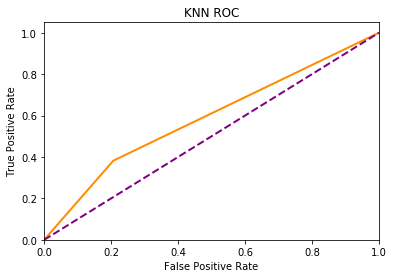

0.587831080915


In [53]:
# Plotting ROC
fpr_k, tpr_k, thresholds = sklearn.metrics.roc_curve(y_test, y_pred)
a = roc_auc_score(y_test, y_pred)
plt.figure()
lw = 2
plt.plot(fpr_k, tpr_k, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='purple', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC')
plt.legend(loc="lower right")
plt.show()
print(a)

In [54]:
confusion_matrix(y_test, y_pred)


array([[9986, 2599],
       [6746, 4173]])

In [55]:
#--------------------------------------RFC--------------------------------------------

In [102]:
# Much better score. I will attempt to tune
rfc = ensemble.RandomForestClassifier()
y = df['FGM']
X = df[['CLOSE_DEF_DIST', 'SHOT_DIST', 'TOUCH_TIME']]
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred_test = rfc.predict(X_test)
rfc.score(X_test, y_test)  

0.55926650782845477

In [103]:
cross_val_score(rfc, X, y, cv=5)

array([ 0.56177072,  0.5631328 ,  0.55632236,  0.5584563 ,  0.55539412])

In [104]:
# ['TOUCH_TIME_SQUARED'] seems to actually make it worse
rfc = ensemble.RandomForestClassifier()
y = df['FGM']
X = df[['CLOSE_DEF_DIST', 'SHOT_DIST', 'TOUCH_TIME_SQUARED']]
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred_test = rfc.predict(X_test)
rfc.score(X_test, y_test)  

0.5586283185840708

In [105]:
cross_val_score(rfc, X, y, cv=5)

array([ 0.56036322,  0.55673099,  0.55505108,  0.55950057,  0.55562114])

In [106]:
# After tuning in multiple directions I settled on a depth of 6
rfc = ensemble.RandomForestClassifier(max_depth=6)
y = df['FGM']
X = df[['CLOSE_DEF_DIST', 'SHOT_DIST', 'TOUCH_TIME']]
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred_test = rfc.predict(X_test)
rfc.score(X_test, y_test)  

0.60857726344452012

In [107]:
cross_val_score(rfc, X, y, cv=5)

array([ 0.61779796,  0.61275823,  0.61035187,  0.60808173,  0.60978932])

In [108]:
# Adding ['PERIOD'] helps slightly. It could mean that players are more warmed up later, 
# have more energy earlier, or care more late in the game.
rfc = ensemble.RandomForestClassifier(max_depth=6)
y = df['FGM']
X = df[['CLOSE_DEF_DIST', 'SHOT_DIST', 'TOUCH_TIME', 'PERIOD']]
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred_test = rfc.predict(X_test)
rfc.score(X_test, y_test)  

0.60998127978216476

In [109]:
cross_val_score(rfc, X, y, cv=5)

array([ 0.61802497,  0.61589103,  0.60948922,  0.60835414,  0.61156012])

In [110]:
# Dribbles seems to make it worse
rfc = ensemble.RandomForestClassifier(n_estimators=25, max_depth=6)
y = df['FGM']
X = df[['CLOSE_DEF_DIST', 'SHOT_DIST', 'TOUCH_TIME', 'PERIOD', 'DRIBBLES']]
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred_test = rfc.predict(X_test)
rfc.score(X_test, y_test)  

0.60887508509189925

In [111]:
cross_val_score(rfc, X, y, cv=5)

array([ 0.61970488,  0.61402951,  0.61085131,  0.60553916,  0.60938068])

In [112]:
df.columns

Index(['FINAL_MARGIN', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK',
       'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT',
       ...
       '201572', '203141', '203486', '708', '101187', '101114', '2207',
       '202366', '202711', '101127'],
      dtype='object', length=316)

In [115]:
# Manipulated different['DRIBBLES'] features and none added value
rfc = ensemble.RandomForestClassifier(max_depth=6)
y = df['FGM']
X = df[['CLOSE_DEF_DIST', 'SHOT_DIST', 'TOUCH_TIME_SQUARED', 'PERIOD', 'DRIBBLES']]
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred_test = rfc.predict(X_test)
rfc.score(X_test, y_test)  

0.60981109598366234

In [116]:
# ['DIST_DIST'] seems to help
rfc = ensemble.RandomForestClassifier(max_depth=6)
y = df['FGM']
X = df[['CLOSE_DEF_DIST', 'SHOT_DIST', 'TOUCH_TIME_SQUARED', 'PERIOD', 'DIST_DIST']]
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred_test = rfc.predict(X_test)
rfc.score(X_test, y_test)  

0.60747106875425461

In [117]:
# More feature experimentation
rfc = ensemble.RandomForestClassifier(max_depth=6)
y = df['FGM']
X = df[['CLOSE_DEF_DIST', 'SHOT_DIST', 'DRIBBLES-TT', 'PERIOD', 'FINAL_MARGIN']]
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred_test = rfc.predict(X_test)
rfc.score(X_test, y_test)  

0.60704560925799866

In [118]:
# More feature experimentation
rfc = ensemble.RandomForestClassifier(max_depth=6)
y = df['FGM']
X = df[['CLOSE_DEF_DIST', 'SHOT_DIST', 'DRIBBLES-TT', 'PERIOD', 'IS_THREE']]
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred_test = rfc.predict(X_test)
rfc.score(X_test, y_test)  

0.60755616065350582

In [119]:
# We will cap it at two standard deviations and round up to ten. I would sometimes say that 
# even ten feet is a bit long but this could help decide between an open three in transition
# or getting closer for a more contested shot.
df['CLOSE_DEF_DIST'].describe()

count    110124.000000
mean          3.689032
std           2.021923
min           0.000000
25%           2.200000
50%           3.400000
75%           5.000000
max          10.000000
Name: CLOSE_DEF_DIST, dtype: float64

In [120]:
df.columns

Index(['FINAL_MARGIN', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK',
       'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT',
       ...
       '201572', '203141', '203486', '708', '101187', '101114', '2207',
       '202366', '202711', '101127'],
      dtype='object', length=316)

In [121]:
rfc = ensemble.RandomForestClassifier(n_estimators=30, max_depth=6)
y = df['FGM']
X = df[['FINAL_MARGIN', 'PERIOD', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 
        'TOUCH_TIME_SQUARED', 'TOUCH_TIME_THIRD', 'DISTANCE_RECIP', 'DIST_DIST', 'DRIBBLES_SQUARED', 'DRIBBLES_SQRT', 
        'DRIBBLES_THIRD', 'DRIBBLES-TT', 'SHOT_NUMBER']]
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred_test = rfc.predict(X_test)
rfc.score(X_test, y_test) 



0.61176820966643974

In [122]:
cross_val_score(rfc, X, y, cv=5)

array([ 0.61834279,  0.61507378,  0.61026107,  0.60694665,  0.61110607])

In [123]:
importances = rfc.feature_importances_
print(importances)

[ 0.02924005  0.00348007  0.00472732  0.03838616  0.28919792  0.06750592
  0.04481253  0.03657758  0.06407065  0.38290194  0.01018711  0.00432109
  0.00724423  0.01205333  0.0052941 ]


/Users/kylehoward/Desktop/Thinkful/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


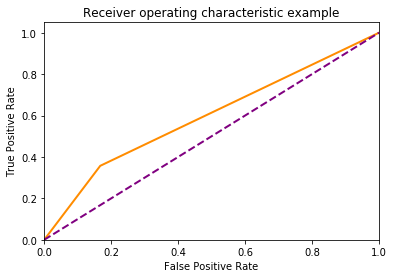

In [124]:
# Plotting ROC
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_pred_test)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='purple', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [125]:
rfc = ensemble.RandomForestClassifier(n_estimators=30, max_depth=6)
y = df['FGM']
X = df[['FINAL_MARGIN', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'TOUCH_TIME_SQUARED', 'TOUCH_TIME_THIRD', 
        'DISTANCE_RECIP', 'DIST_DIST', 'D_!', 'S_IS_CLOSE', 'S_IS_LONG']]
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred_test = rfc.predict(X_test)
rfc.score(X_test, y_test) 

0.61261912865895163

In [126]:
cross_val_score(rfc, X, y, cv=5)

array([ 0.61929625,  0.615437  ,  0.60871737,  0.60740068,  0.61174174])

In [127]:
importances = rfc.feature_importances_
print(importances)

[ 0.03430157  0.04327758  0.22535706  0.06633676  0.06307625  0.04545805
  0.09088367  0.25192258  0.01769651  0.10514746  0.0565425 ]


In [128]:
confusion_matrix(y_test, y_pred_test)

array([[10702,  1883],
       [ 7222,  3697]])

/Users/kylehoward/Desktop/Thinkful/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


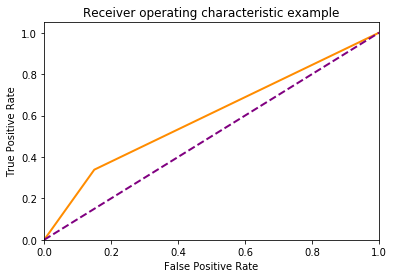

0.587831080915


In [129]:
# Plotting ROC
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_pred_test)
a = roc_auc_score(y_test, y_pred)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='purple', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print(a)

In [130]:
# Good but still below best model
rfc = ensemble.RandomForestClassifier(max_depth=6)
y = df['FGM']
X = df[['CLOSE_DEF_DIST', 'DIST_DIST', 'SHOT_DIST', 'DRIBBLES-TT', 'PERIOD', 'IS_THREE', 'D_!', 'D_2', 'D_3', 'D_4', 'D_5', 'S_IS_CLOSE', 'S_IS_SHORT', 'S_IS_MID', 'S_IS_LONG']]
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred_test = rfc.predict(X_test)
rfc.score(X_test, y_test)  

0.60751361470388021

In [131]:
# Worse then previous
rfc = ensemble.RandomForestClassifier(max_depth=6)
y = df['FGM']
X = df[['CLOSE_DEF_DIST', 'SHOT_DIST', 'DRIBBLES-TT', 'PERIOD', 'IS_THREE']]
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred_test = rfc.predict(X_test)
rfc.score(X_test, y_test)  

0.60755616065350582

In [132]:
# All new categorical variables paired with five previous best performing
rfc = ensemble.RandomForestClassifier(max_depth=6)
y = df['FGM']
X = df[['CLOSE_DEF_DIST', 'SHOT_DIST', 'TOUCH_TIME', 'PERIOD', 'DIST_DIST', 'D_!', 'D_2', 'D_3', 'D_4', 'D_5', 'S_IS_CLOSE', 'S_IS_SHORT', 'S_IS_MID', 'S_IS_LONG']]
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred_test = rfc.predict(X_test)
rfc.score(X_test, y_test)  

0.60713070115724987

In [133]:
cross_val_score(rfc, X, y, cv=5)

array([ 0.61875142,  0.61475596,  0.60830874,  0.60508513,  0.60951689])

In [134]:
importances = rfc.feature_importances_
print(importances)

[ 0.09406349  0.15998677  0.05946901  0.00515824  0.43813483  0.02372384
  0.01061034  0.01447312  0.00393683  0.00332847  0.05900426  0.0194342
  0.01202811  0.09664847]


In [135]:
# Just new categorical
rfc = ensemble.RandomForestClassifier(max_depth=6)
y = df['FGM']
X = df[['D_!', 'D_2', 'D_3', 'D_4', 'D_5', 'S_IS_CLOSE', 'S_IS_SHORT', 'S_IS_MID', 'S_IS_LONG']]
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred_test = rfc.predict(X_test)
rfc.score(X_test, y_test)  

0.59977025187202182

In [136]:
importances = rfc.feature_importances_
print(importances)

[ 0.08608401  0.03849073  0.08104304  0.04464247  0.02529614  0.39776746
  0.08890327  0.04350442  0.19426847]


In [172]:
# Best five without categorical is basically identical to with. I will drop new variables
# for feature reduction sake
rfc = ensemble.RandomForestClassifier(n_estimators=250, max_depth=6)
y = df['FGM']
X = df[['CLOSE_DEF_DIST', 'SHOT_DIST', 'TOUCH_TIME', 'PERIOD', 'DIST_DIST']]
#X = normalize(X)
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred_test = rfc.predict(X_test)
rfc.score(X_test, y_test) 

0.61117256637168138

In [173]:
cross_val_score(rfc, X, y, cv=5)

array([ 0.61916005,  0.61353008,  0.60889898,  0.60708286,  0.61128769])

In [174]:
# 64.8% on selecting 'made' 60.9% on selecting missed
confusion_matrix(y_test, y_pred)

array([[9986, 2599],
       [6746, 4173]])

/Users/kylehoward/Desktop/Thinkful/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


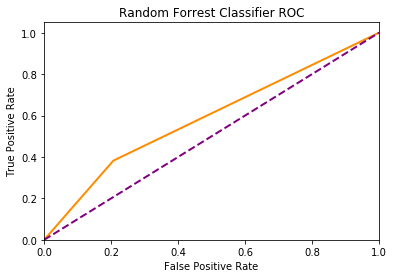

0.587831080915


In [175]:
# Plotting ROC
fpr_r, tpr_r, thresholds = sklearn.metrics.roc_curve(y_test, y_pred)
a = roc_auc_score(y_test, y_pred)
plt.figure()
lw = 2
plt.plot(fpr_r, tpr_r, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='purple', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forrest Classifier ROC')
plt.legend(loc="lower right")
plt.show()
print(a)

In [176]:
# Feature stregnth. ['DIST_DIST'] is most successful with ['SHOT_DIST'] following
importances = rfc.feature_importances_
print(importances)

[ 0.15036538  0.3340441   0.11795386  0.00472784  0.39290881]


In [84]:
# Attempt to reduce features further
rfc = ensemble.RandomForestClassifier(max_depth=5)
y = df['FGM']
X = df[['SHOT_DIST', 'DIST_DIST']]
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred_test = rfc.predict(X_test)
rfc.score(X_test, y_test) 

0.60535396462169921

In [45]:
cross_val_score(rfc, X, y, cv=5)

array([ 0.61393871,  0.6093076 ,  0.60435868,  0.60254257,  0.60411369])

In [46]:
confusion_matrix(y_test, y_pred)

array([[14777,  3010],
       [ 9819,  5432]])

In [47]:
importances = rfc.feature_importances_
print(importances)

[ 0.39980472  0.60019528]


/Users/kylehoward/Desktop/Thinkful/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


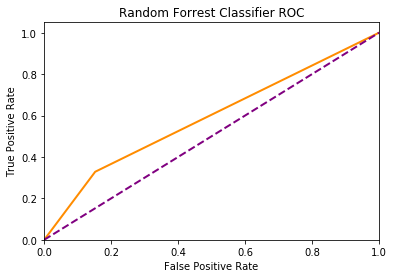

In [55]:
# Plotting ROC
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_pred)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='purple', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forrest Classifier ROC')
plt.legend(loc="lower right")
plt.show()

In [379]:
# Comparing our model to season long FG%
hit = df["FGM"].sum()
tot = len(df['FGM'])
percent = hit / tot
print(percent)

0.4551136411625098


In [380]:
# Creating predictions per shot so we can evaluate shot quality as a side effect
predictions = rfc.predict_proba(X)
print(predictions)

[[ 0.59769681  0.40230319]
 [ 0.65753433  0.34246567]
 [ 0.60941529  0.39058471]
 ..., 
 [ 0.35340412  0.64659588]
 [ 0.60203366  0.39796634]
 [ 0.6025729   0.3974271 ]]


In [381]:
# Adding the prediction of shot made to the DF
prediction = []
for pred in predictions:
    pred = pred[1]
    prediction.append(pred)
df['PREDICTION'] = prediction
df.head(50)

,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,...,DRIBBLES_THIRD,DRIBBLES_LOG,DRIBBLES-TT,TT_SQ_DR,D_!,D_2,D_3,D_4,D_5,PREDICTION
0,24,1,1,1:09,10.8,2,1.9,7.7,2,made,...,8,0.693147,7.22,3.610000e+00,0,0,0,0,0,0.402303
1,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,...,0,-inf,0.00,1.000000e+00,0,0,0,0,0,0.342466
3,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,...,8,0.693147,7.22,3.610000e+00,0,0,0,0,0,0.390585
4,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,...,8,0.693147,14.58,7.290000e+00,0,0,0,0,0,0.598688
5,24,6,2,8:15,9.1,2,4.4,18.4,2,missed,...,8,0.693147,38.72,1.936000e+01,0,0,0,0,0,0.385852
6,24,7,4,10:15,14.5,11,9.0,20.7,2,missed,...,1331,2.397895,891.00,3.138106e+10,0,0,0,0,0,0.381681
7,24,8,4,8:00,3.4,3,2.5,3.5,2,made,...,27,1.098612,18.75,1.562500e+01,0,0,0,0,0,0.611235
8,24,9,4,5:14,12.4,0,0.8,24.6,3,missed,...,0,-inf,0.00,1.000000e+00,0,0,0,0,0,0.350055
10,1,2,2,6:30,16.0,8,7.5,24.5,3,missed,...,512,2.079442,450.00,1.001129e+07,1,0,0,0,0,0.352742
11,1,3,4,11:32,12.1,14,11.9,14.6,2,made,...,2744,2.639057,1982.54,1.141977e+15,1,0,0,0,0,0.413750


In [26]:
#-------------------------Sklearn Logistic regression------------------------------------
lr = LogisticRegression(C=25)
y = df['FGM']
X = df[['CLOSE_DEF_DIST', 'SHOT_DIST', 'TOUCH_TIME_SQUARED', 'PERIOD', 'DIST_DIST']]
X = pd.concat([X, players], axis=1, ignore_index=True)
X_training = X[:82593]
y_training = y[:82593]
X_test = X[82593:]
y_test = y[82593:]
fit = lr.fit(X_training, y_training)
pred_y_sklearn = lr.predict(X_test)
print('\n FGM')
print(pd.crosstab(pred_y_sklearn, y_test))
print('\n Percentage accuracy')
print(lr.score(X_test, y_test))



 FGM
FGM        0     1
row_0             
0      10840  7097
1       3912  5682

 Percentage accuracy
0.600123497149


/Users/kylehoward/Desktop/Thinkful/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


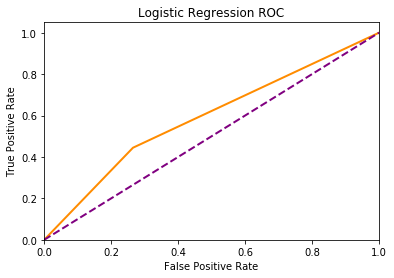

0.589725674358


In [27]:
# Plotting ROC
fpr_l, tpr_l, thresholds = sklearn.metrics.roc_curve(y_test, pred_y_sklearn)
plt.figure()
a = roc_auc_score(y_test, pred_y_sklearn)
lw = 2
plt.plot(fpr_l, tpr_l, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='purple', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC')
plt.legend(loc="lower right")
plt.show()
print(a)

In [12]:
#-------------------------------SVC--------------------------------
svm = SVC(C=5)
y = df['FGM']
X = df[['CLOSE_DEF_DIST', 'SHOT_DIST', 'TOUCH_TIME_SQUARED', 'PERIOD', 'DIST_DIST']]
#X = pd.concat([X, players], axis=1, ignore_index=True)
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
svm.fit(X_training, y_training)


SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
y_pred_test = svm.predict(X_test)
print(y_pred_test)

[0 0 0 ..., 1 0 1]


In [14]:
svm.score(X_test, y_test)

0.5717917983364208

/Users/kylehoward/Desktop/Thinkful/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


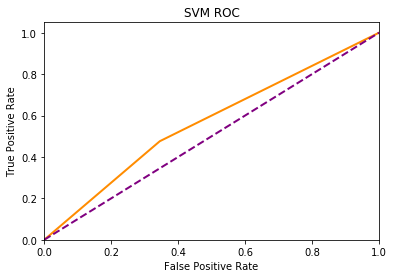

0.565392240209


In [15]:
# Plotting ROC
fpr_s, tpr_s, thresholds = sklearn.metrics.roc_curve(y_test, y_pred_test)
a = roc_auc_score(y_test, y_pred_test)
plt.figure()
lw = 2
plt.plot(fpr_s, tpr_s, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='purple', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC')
plt.legend(loc="lower right")
plt.show()
print(a)

In [391]:
#----------------------Visuailzations----------------------------

In [128]:
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
)
decision_tree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [131]:
# My concern with this is that it is half of the depth of the actual model but that tree 
# is too wide to fit on a slide
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Missed', 'Made'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

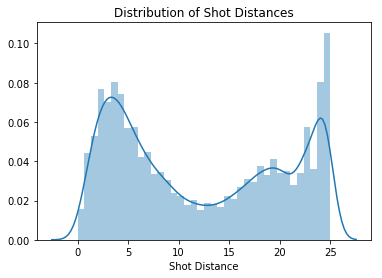

In [36]:
# Will make these more visually appealing if i end up using them
z = df['SHOT_DIST']
plt.xlabel('Shot Distance')
sns.distplot(z)
plt.title('Distribution of Shot Distances')
plt.xlabel('Shot Distance')

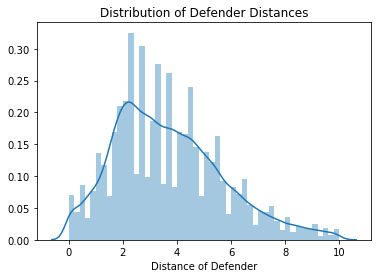

In [37]:
z = df['CLOSE_DEF_DIST']
plt.xlabel('Distance of Defender')
sns.distplot(z)
plt.title('Distribution of Defender Distances')
plt.xlabel('Distance of Defender')

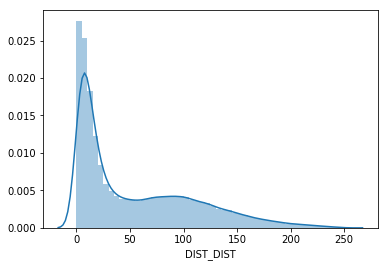

In [424]:
z = df['DIST_DIST']
sns.distplot(z)

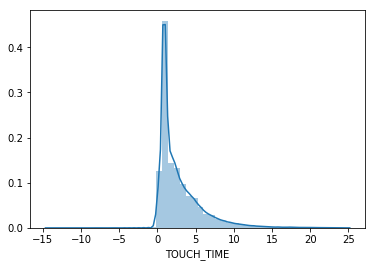

In [425]:
z = df['TOUCH_TIME']
sns.distplot(z)

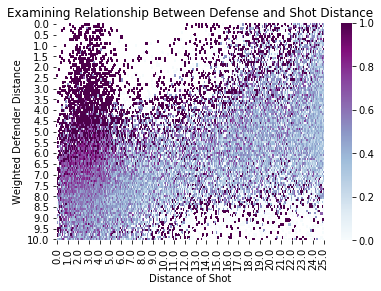

In [39]:

x = df['SHOT_DIST']
y = df['FGM']
z = df['DISTANCE_RECIP']
df_ = pd.DataFrame()
df_['SHOT_DIST'] = x
df_['FGM'] = y
df_['DISTANCE_RECIP'] = z
x = pd.Series(x, name="Distance of Shot")
y = pd.Series(z, name="Weighted Defender Distance")
df_ = df_.groupby(['DISTANCE_RECIP','SHOT_DIST'], as_index=False).mean()
df_ = df_.pivot(index='DISTANCE_RECIP', columns='SHOT_DIST', values='FGM')
sns.heatmap(df_, cmap='BuPu')
plt.title('Examining Relationship Between Defense and Shot Distance')
plt.xlabel('Distance of Shot')
plt.ylabel('Weighted Defender Distance')

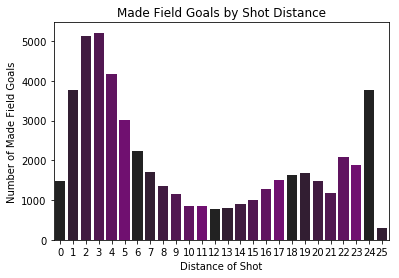

In [40]:
df_2 = pd.DataFrame()
df_2['SHOT_DIST'] = df['SHOT_DIST']
df_2['FGM'] = df['FGM']
df_2['SHOT_DIST'] = df_2['SHOT_DIST'].astype(int)
df_2.round()
df_2 = df_2.groupby(['SHOT_DIST'], as_index=False).sum()
df_2.head()
dark = sns.dark_palette("purple")
sns.barplot(x='SHOT_DIST', y='FGM', data=df_2, palette=dark)
plt.title('Made Field Goals by Shot Distance')
plt.xlabel('Distance of Shot')
plt.ylabel('Number of Made Field Goals')

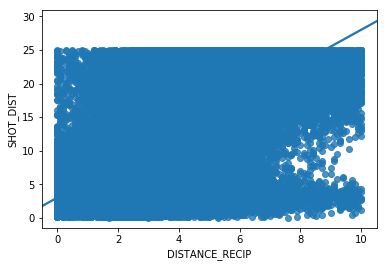

In [19]:
x = df['DISTANCE_RECIP']
y = df['SHOT_DIST']
sns.regplot(x=x, y=y, data=df)
plt.show()

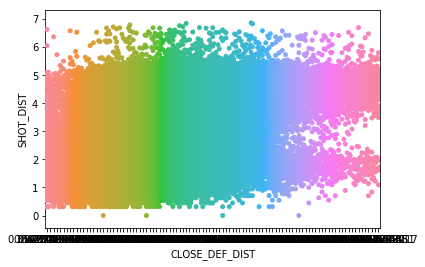

In [94]:
# Not sure how to visualize these two features
outcome = df['CLOSE_DEF_DIST'] ** .5
feature = df['SHOT_DIST'] ** .5

sns.swarmplot(outcome, feature)

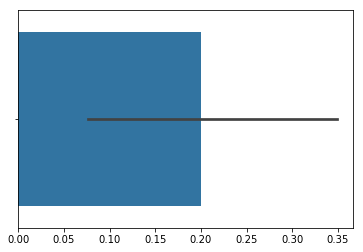

In [51]:
z = [0.16871077, 0.45964535, 0.11960062, 0.00448858, 0.24755467]
z_1 = pd.DataFrame(z)
sns.barplot(z_1)

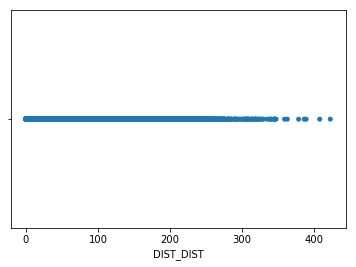

In [141]:
sns.stripplot(df['DIST_DIST'])

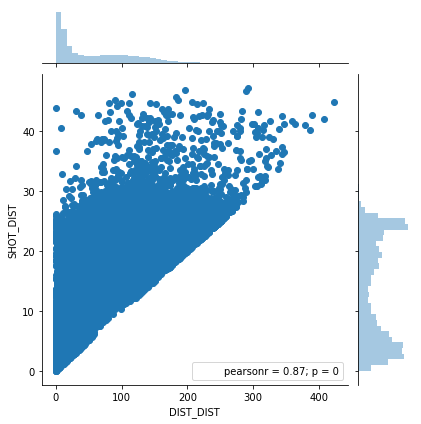

In [164]:
z = df[['DIST_DIST', 'SHOT_DIST']]
sns.jointplot(x=df['DIST_DIST'], y=df['SHOT_DIST'])

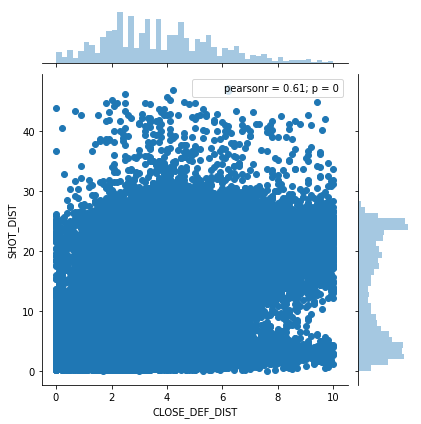

In [176]:
z = df[['CLOSE_DEF_DIST', 'SHOT_DIST']]
sns.jointplot(x=df['CLOSE_DEF_DIST'], y=df['SHOT_DIST'])

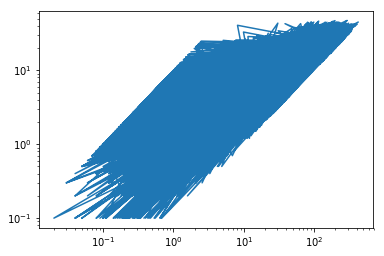

In [170]:
a = df['DIST_DIST']
b = df['SHOT_DIST']

a = plt.loglog(a,b)

<Container object of 5 artists>

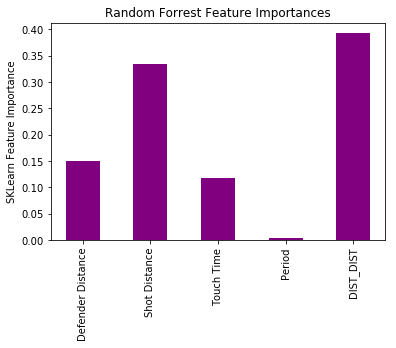

In [177]:
import matplotlib.pyplot as plt
labels = ['Defender Distance', 'Shot Distance', 'Touch Time', 'Period', 'DIST_DIST']
plt.xticks(x, labels, rotation='vertical')
#plt.xlabel(['Defender Distance', 'Shot Distance', 'TT^2', 'DIST_DIST', 'Period'])
plt.ylabel('SKLearn Feature Importance')
plt.title('Random Forrest Feature Importances')
y = importances
N = len(y)
x = range(N)
#plt.xticks('A', 'B', 'C', 'D', 'E')
width = .5
plt.bar(x, y, width, color="purple")

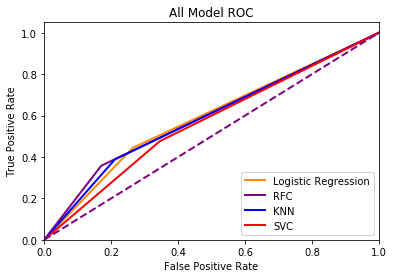

In [33]:
plt.plot(fpr_l, tpr_l, color='darkorange',
         lw=lw, label='Logistic Regression')
plt.plot(fpr_r, tpr_r, color='purple',
         lw=lw, label='RFC')
plt.plot(fpr_k, tpr_k, color='blue',
         lw=lw, label='KNN')
plt.plot(fpr_s, tpr_s, color='red',
         lw=lw, label='SVC')
plt.plot([0, 1], [0, 1], color='purple', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All Model ROC')
plt.legend(loc="lower right")
plt.show()
